<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula05b_single_hidden_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

def plotDataset(X, y):
  plt.scatter(X[:,0], X[:,1], c=y)

In [2]:
def plotHiperplano(vector, intercept=0, dataset=None):
  xs = np.array([0, 1])
  ys = -(vector[0]*xs+intercept)/vector[1]
  plt.plot(xs, ys, 'r-')

In [3]:
def sign(a):
  return (a>=0)*2-1

In [4]:
import numpy as np
from sklearn.datasets import make_blobs

def criaDataset(n=40, func=lambda a, b: bool(a) != bool(b)):
  X, y = make_blobs(n_samples=n, centers=[[0,0],[1,0],[1,1],[0,1]], cluster_std=0.1)
  y = np.array([func(a>0.5, b>0.5) for a, b in zip(X[:,0], X[:,1])], dtype=int)*2-1
  return X, y

X, y = criaDataset()

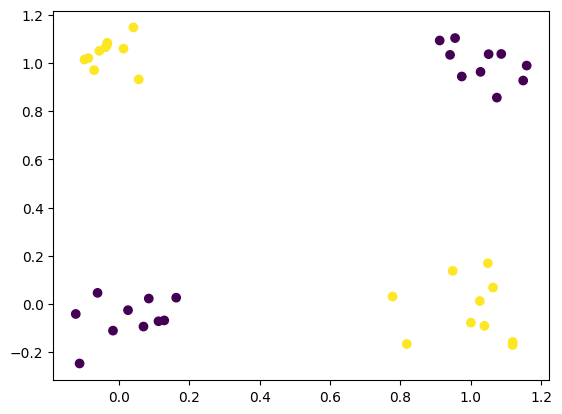

In [5]:
plotDataset(X, y)
plt.show()

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

In [7]:
include_bias = lambda X: np.c_[np.ones(X.shape[0]), X]

In [8]:
from scipy.special import expit

def tanh(a):
  return expit(a)*2-1

In [9]:
def defineAxes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

0.95


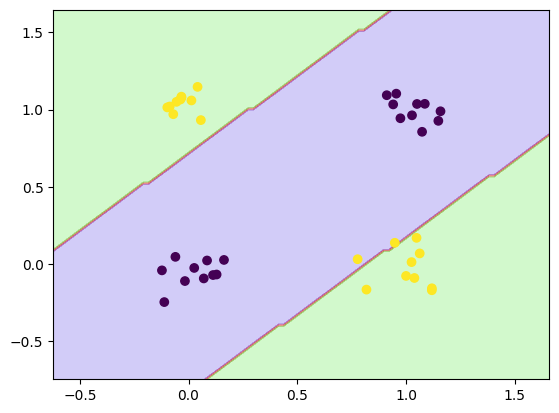

In [10]:
class SingleHiddenLayer(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=1000, learning_rate=0.005):
    self.max_iter = max_iter
    self.learning_rate = learning_rate

  def fit(self, X, y):
    Xb = include_bias(X)
    self.ihw = np.array([[1.74, -0.9, 0.9], [1.74, 0.9, -0.9]]).T
    pH = Xb @ self.ihw
    H = tanh(pH)
    Hb = include_bias(H)
    if len(y.shape) == 1:
      y = y.reshape(-1, 1)
    self.how = np.random.uniform(-1, 1, size=(Hb.shape[1], y.shape[1]))
    for _ in range(self.max_iter):
      ypred = Hb @ self.how
      error = y - ypred
      self.how += Hb.T @ error * self.learning_rate
      self.cost_ = np.sum((error)**2)
    return self

  def predict(self, X):
    Xb = include_bias(X)
    pH = Xb @ self.ihw
    H = tanh(pH)
    Hb = include_bias(H)
    ypred = Hb @ self.how
    return sign(ypred)

model = SingleHiddenLayer()
model.fit(X, y)
print(accuracy_score(y, model.predict(X)))
plotPredictions(model, X)
plotDataset(X, y)
plt.show()

0.975


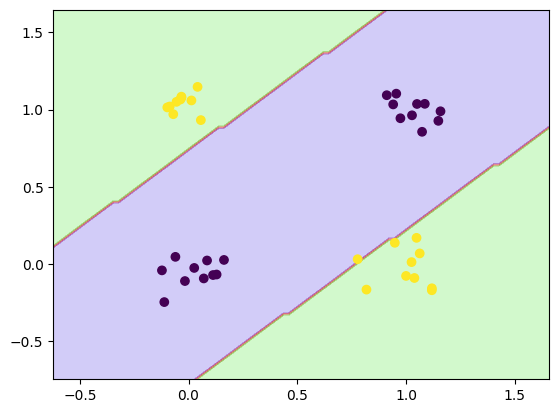

In [15]:
class SingleHiddenLayer(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=1000, learning_rate=0.01):
    self.max_iter = max_iter
    self.learning_rate = learning_rate

  def foward(self, X):
    Xb = include_bias(X)
    pH = Xb @ self.ihw
    H = tanh(pH)
    self.Hb = include_bias(H)
    ypred = self.Hb @ self.how
    return ypred

  def backward(self, y, ypred):
    error = y - ypred
    self.how += self.Hb.T @ error * self.learning_rate
    self.cost_ = np.sum((error)**2)

  def fit(self, X, y):
    Xb = include_bias(X)
    if len(y.shape) == 1:
      y = y.reshape(-1, 1)
    self.ihw = np.array([[1.74, -0.9, 0.9], [1.74, 0.9, -0.9]]).T
    self.how = np.random.uniform(-1, 1, size=(self.ihw.shape[1]+1, y.shape[1]))
    for _ in range(self.max_iter):
      ypred = self.foward(X)
      self.backward(y, ypred)
    return self

  def predict(self, X):
    ypred = self.foward(X)
    return sign(ypred)

model = SingleHiddenLayer()
model.fit(X, y)
print(accuracy_score(y, model.predict(X)))
plotPredictions(model, X)
plotDataset(X, y)
plt.show()

1.0


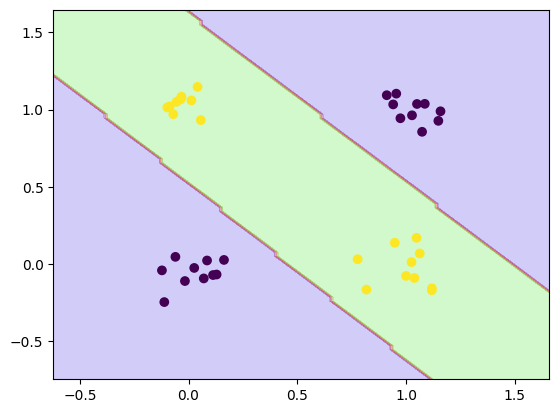

In [47]:
class SingleHiddenLayer(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=1000, learning_rate=0.01):
    self.max_iter = max_iter
    self.learning_rate = learning_rate

  def foward(self, X):
    Xb = include_bias(X)
    pH = Xb @ self.ihw
    self.H = tanh(pH)
    self.Hb = include_bias(self.H)
    ypred = self.Hb @ self.how
    return ypred

  def backward(self, Xb, y, ypred):
    ho_delta = y - ypred
    ho_grad = self.Hb.T @ ho_delta
    ### PULO DO GATO ###
    tanh_grad = (1 - np.square(self.H))
    ih_delta = (ho_delta @ self.how[1:, :].T) * tanh_grad
    ### #### ## #### ###
    ih_grad = Xb.T @ ih_delta
    self.how += ho_grad * self.learning_rate
    self.ihw += ih_grad * self.learning_rate
    self.cost_ = np.sum((ho_delta)**2)

  def fit(self, X, y):
    Xb = include_bias(X)
    if len(y.shape) == 1:
      y = y.reshape(-1, 1)
    self.ihw = np.random.uniform(-1, 1, size=(Xb.shape[1], 2))
    self.how = np.random.uniform(-1, 1, size=(self.ihw.shape[1]+1, y.shape[1]))
    for _ in range(self.max_iter):
      ypred = self.foward(X)
      self.backward(Xb, y, ypred)
    return self

  def predict(self, X):
    ypred = self.foward(X)
    return sign(ypred)

model = SingleHiddenLayer()
model.fit(X, y)
print(accuracy_score(y, model.predict(X)))
plotPredictions(model, X)
plotDataset(X, y)
plt.show()